In [1]:
%matplotlib inline
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
import numpy as np
import numba as nb

In [2]:
# This is a helper function which adds up the mass of two 4-vectors based on their components.
@nb.njit()
def massAddition(l1_px, l1_py, l1_pz, l1_E,
                 l2_px, l2_py, l2_pz, l2_E):
    return np.sqrt((l1_E + l2_E)**2 - 
                  ((l1_px + l2_px)**2 + 
                   (l1_py + l2_py)**2 + 
                   (l1_pz + l2_pz)**2))

# This is a helper function which determines how far the mass of a pair of leptons is from the Z mass.
@nb.njit()
def massFromZ(l1_px, l1_py, l1_pz, l1_E,
              l2_px, l2_py, l2_pz, l2_E):
    mass_Z = 91.1867
    mass_ll = massAddition(l1_px, l1_py, l1_pz, l1_E,
                           l2_px, l2_py, l2_pz, l2_E)
    return np.abs(mass_ll - mass_Z)

# This is a helper function which adds up the transverse momentum of two leptons from their x and y components.
@nb.njit()
def ptAddition(l1_px, l1_py, l2_px, l2_py):
    return np.sqrt((l1_px + l2_px)**2 + (l1_py + l2_py)**2)

# This is a helper function which gets all pairs of values of an input array.
@nb.njit()
def combinations(array):
    combos = [(0, 0)]
    for i in array:
        for j in array:
            if ((i, j) not in combos) and ((j, i) not in combos) and (j != i):
                combos.append((i, j))
    return combos[1:]
            

# This filter takes in relevant loose lepton components and outputs an event-level Boolean array of events which pass the requirement that lepton pair mass is > 12.
def looseFilter(loose_e_starts, loose_e_stops, loose_mu_starts, loose_mu_stops,
               loose_e_px, loose_e_py, loose_e_pz, loose_e_E,
               loose_mu_px, loose_mu_py, loose_mu_pz, loose_mu_E):
    
    # All events pass, if they do not, we turn the 1's to 0's.
    final_mask = np.ones(loose_e_starts.size, dtype=np.bool_)
    
    # With the starts and stops, we can get each event's data per-event, and work with concatenated e's and mu's.
    for e_start, e_stop, mu_start, mu_stop, i in zip(loose_e_starts, loose_e_stops, loose_mu_starts, loose_mu_stops, range(0, loose_e_starts.size)):
        event_E = np.concatenate((loose_e_E[e_start:e_stop], loose_mu_E[mu_start:mu_stop]))
        event_px = np.concatenate((loose_e_px[e_start:e_stop], loose_mu_px[mu_start:mu_stop]))
        event_py = np.concatenate((loose_e_py[e_start:e_stop], loose_mu_py[mu_start:mu_stop]))
        event_pz = np.concatenate((loose_e_pz[e_start:e_stop], loose_mu_pz[mu_start:mu_stop]))
        # This handles empty events.
        if event_E.size == 0:
            final_mask[i] = 0
        # Generate every pair, check that their combined mass is greater than 12 (if not, change 1 to 0 in mask)
        for combination in np.array(combinations(np.argsort(event_E))):
            if 12 > (massAddition(event_px[combination[0]], event_py[combination[0]], event_pz[combination[0]], event_E[combination[0]],
                           event_px[combination[1]], event_py[combination[1]], event_pz[combination[1]], event_E[combination[1]])):
                final_mask[i] = 0
    return final_mask

# *muons pt/pt and triple charge consistent
# This filter takes in relevant tight lepton components and outputs an event-level Boolean array of events which pass the requirements for the di- and tri-lepton channels.
    # Dilepton: Exactly 2 tight leptons, no ee events such that |m_ee - m_Z| < 10, triple charge consistent e's, mmuons with del_pt/pt < 0.2
    # Trilepton: Exactly 3 tight leptons, pT > 25/15/15, no OSSF pair with |m_ll - m_Z| < 15
def leptonChannels(tight_e_starts, tight_e_stops, tight_mu_starts, tight_mu_stops,
                tight_e_px, tight_e_py, tight_e_pz, tight_e_E,
                tight_mu_px, tight_mu_py, tight_mu_pz, tight_mu_E,
                tight_e_pt, tight_mu_pt, e_charge, mu_charge):
    
    dilepton_mask = np.ones(tight_e_starts.size, dtype=np.bool_)
    trilepton_mask = np.ones(tight_e_starts.size, dtype=np.bool_)
    
    for e_start, e_stop, mu_start, mu_stop, i in zip(tight_e_starts, tight_e_stops, tight_mu_starts, tight_mu_stops, range(0, tight_e_starts.size)):
        event_pt = np.concatenate((tight_e_pt[e_start:e_stop], tight_mu_pt[mu_start:mu_stop]))
        event_E = np.concatenate((tight_e_E[e_start:e_stop], tight_mu_E[mu_start:mu_stop]))
        event_px = np.concatenate((tight_e_px[e_start:e_stop], tight_mu_px[mu_start:mu_stop]))
        event_py = np.concatenate((tight_e_py[e_start:e_stop], tight_mu_py[mu_start:mu_stop]))
        event_pz = np.concatenate((tight_e_pz[e_start:e_stop], tight_mu_pz[mu_start:mu_stop]))
        event_charge = np.concatenate((e_charge[e_start:e_stop], mu_charge[mu_start:mu_stop]))

        flavor = np.empty(3, dtype=str)
        
        # Events with exactly 2 leptons
        if not (event_pt.size == 2):
            dilepton_mask[i] = 0
        else:
            if not ((event_pt[0] > 25) & (event_pt[1] > 15)):
                dilepton_mask[i] = 0
            if ((tight_e_pt.size == 2) & 
                (10 > massFromZ(event_px[0], event_py[0], event_pz[0], event_E[0],
                                event_px[1], event_py[1], event_pz[1], event_E[1]))
               ):
                dilepton_mask[i] = 0
                
        # Events with exactly 3 leptons
        if not (event_pt.size == 3):
            trilepton_mask[i] = 0
        elif not((event_pt[0] > 25) & (event_pt[1] > 15) & (event_pt[2] > 15)):
            trilepton_mask[i] = 0
        else:
            flavor[0:(e_stop - e_start)] = 'e'
            flavor[(e_stop-e_start):] = 'm'
            for combination in np.array(combinations(np.argsort(event_pt))):
                if ((event_charge[combination[0]] != event_charge[combination[1]]) &
                    (flavor[combination[0]] == flavor[combination[1]]) &
                    (15 < massFromZ(event_px[combination[0]], event_py[combination[0]], event_pz[combination[0]], event_E[combination[0]],
                                    event_px[combination[1]], event_py[combination[1]], event_pz[combination[1]], event_E[combination[1]]))
                   ):
                    trilepton_mask[i] = 0            
    return dilepton_mask, trilepton_mask

# This takes as input leptons in a cross-lepton channel (lll or e-mu) and outputs a lowest-pt lepton mask.
def channel_subpt(e_starts, e_stops, mu_starts, mu_stops,
                  e_pt, mu_pt):
    e_mask = np.zeros(e_starts.size, dtype=np.bool_)
    mu_mask = np.zeros(mu_starts.size, dtype=np.bool_)
    for e_start, e_stop, mu_start, mu_stop, i in zip(e_starts, e_stops, mu_starts, mu_stops, range(0, e_starts.size)):
        event_pt = np.concatenate((e_pt[e_start:e_stop], mu_pt[mu_start:mu_stop]))
        if len(event_pt) > 0:
            index = event_pt.argmin()
            if index in range(0, e_stop-e_start):
                e_mask[i] = 1
            else:
                mu_mask[i] = 1
    return e_mask, mu_mask

# This takes as input values from the trilepton channel and outputs an array with del(phi) between the two highest sslps.
def channel_dphi_ssp(e_starts, e_stops, mu_starts, mu_stops,
                     e_px, e_py, e_phi, mu_px, mu_py, mu_phi, 
                     e_charge, mu_charge):
    dphi = np.zeros(e_starts.size)
    dphi.fill(-np.inf)
    for e_start, e_stop, mu_start, mu_stop, i in zip(e_starts, e_stops, mu_starts, mu_stops, range(0, e_starts.size)):
        event_px = np.concatenate((e_px[e_start:e_stop], mu_px[mu_start:mu_stop]))
        event_py = np.concatenate((e_py[e_start:e_stop], mu_py[mu_start:mu_stop]))
        event_phi = np.concatenate((e_phi[e_start:e_stop], mu_phi[mu_start:mu_stop]))
        event_charge = np.concatenate((e_charge[e_start:e_stop], mu_charge[mu_start:mu_stop]))
        maxpt = -np.inf
        pair = (None, None)
        for combination in np.array(combinations(np.argsort(event_px))):
            if (np.abs(event_charge[combination[0]] + event_charge[combination[1]]) == 2):
                pair_pt = ptAddition(event_px[combination[0]], event_py[combination[0]], event_px[combination[1]], event_px[combination[1]])
                if pair_pt > maxpt:
                    maxpt = pair_pt
                    pair = (combination[0], combination[1])
        if pair != (None, None):
            dphi[i] = np.abs(event_phi[pair[0]] - event_phi[pair[1]])
    return dphi[np.invert(np.isinf(dphi))]

# This take as input values from  a cross-lepton channel and outputs the eta difference of the closest leptons (in eta) to each event's most forward jet.
def channel_fwdeta_jetlep(e_starts, e_stops, mu_starts, mu_stops,
                          jet_maxeta, e_eta, mu_eta):
    deta = np.zeros(e_starts.size)
    deta.fill(-np.inf)
    for e_start, e_stop, mu_start, mu_stop, i in zip(e_starts, e_stops, mu_starts, mu_stops, range(0, e_starts.size)):
        jet = jet_maxeta[i]
        event_eta = np.concatenate((e_eta[e_start:e_stop], mu_eta[mu_start:mu_stop]))
        deta[i] = np.min(np.abs(jet - event_eta))
    return deta

In [13]:
class SignalProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "")
        
        lll_3rdLepton_pT_axis = hist.Bin("lll_3rdLepton_pT", "3rd Lepton $p_T$ [GeV]", 20, 0, 100)
        lll_fwdJet_leadbJet_axis = hist.Bin("lll_fwdJet_leadbJet", "$\Delta \eta$ max fwd jet and leading bjet", 20, 0, 10)
        lll_fwdJet_subleadbJet_axis = hist.Bin("lll_fwdJet_subleadbJet", "$\Delta \eta$ max fwd jet and sub-leading bjet", 20, 0, 10)
        lll_fwdJet_closestLepton_axis = hist.Bin("lll_fwdJet_closestLepton", "$\Delta \eta$ max fwd jet and closest lepton", 20, 0, 10)
        lll_highpT_sslp_axis = hist.Bin("lll_highpT_sslp", "$\Delta \Phi$ highest $p_T$ same-sign lepton pair", 20, 0, 5)
        lll_jetMaxEta_axis = hist.Bin("lll_jetMaxEta", "max jet $|\eta|$ ($p_T$ > 25)", 20, 0, 5)
        lll_minDelR_axis = hist.Bin("lll_minDelR", "Minimum $\Delta$ R between any two leptons", 20, 0, 5)
        lll_NJetMedium_axis = hist.Bin("lll_NJetMED", "N(jet, $p_T$ > 25, $|\eta|$ < 2.4)", 20, 0, 10)
        lll_NJetNonCSVMedium_axis = hist.Bin("lll_NJetNONMED", "N(jet, $|\eta|$ > 1) non CSV medium", 20, 0, 10)        
        lll_TotalCharge_axis = hist.Bin("lll_TotalCharge", "Total Lepton Charge", 3, -1.5, 1.5)
        
        mumu_subleadLepton_pT_axis = hist.Bin("mumu_subleadLepton_pT", "Sub-leading Lepton $p_T$ [GeV]", 20, 0, 100)
        mumu_fwdJet_leadbJet_axis = hist.Bin("mumu_fwdJet_leadbJet", "$\Delta \eta$ max fwd jet and leading bjet", 20, 0, 10)
        mumu_fwdJet_subleadbJet_axis = hist.Bin("mumu_fwdJet_subleadbJet", "$\Delta \eta$ max fwd jet and sub-leading bjet", 20, 0, 10)
        mumu_fwdJet_closestLepton_axis = hist.Bin("mumu_fwdJet_closestLepton", "$\Delta \eta$ max fwd jet and closest lepton", 20, 0, 10)
        mumu_highpT_sslp_axis = hist.Bin("mumu_highpT_sslp", "$\Delta \Phi$ highest $p_T$ same-sign lepton pair", 20, 0, 5)
        mumu_jetMaxEta_axis = hist.Bin("mumu_jetMaxEta", "max jet $|\eta|$ ($p_T$ > 40)", 20, 0, 5)
        mumu_minDelR_axis = hist.Bin("mumu_minDelR", "Minimum $\Delta$ R between any two leptons", 20, 0, 5)
        mumu_NJetMedium_axis = hist.Bin("mumu_NJetMED", "N(jet, $p_T$ > 25, $|\eta|$ < 2.4)", 20, 0, 10)
        mumu_NJetNonCSVMedium_axis = hist.Bin("mumu_NJetNONMED", "N(jet, $|\eta|$ > 1) non CSV medium", 20, 0, 10)        
        mumu_TotalCharge_axis = hist.Bin("mumu_TotalCharge", "Total Lepton Charge", 3, -4, 4)
        
        emu_subleadLepton_pT_axis = hist.Bin("emu_subleadLepton_pT", "Sub-leading Lepton $p_T$ [GeV]", 20, 0, 100)
        emu_fwdJet_leadbJet_axis = hist.Bin("emu_fwdJet_leadbJet", "$\Delta \eta$ max fwd jet and leading bjet", 20, 0, 10)
        emu_fwdJet_subleadbJet_axis = hist.Bin("emu_fwdJet_subleadbJet", "$\Delta \eta$ max fwd jet and sub-leading bjet", 20, 0, 10)
        emu_fwdJet_closestLepton_axis = hist.Bin("emu_fwdJet_closestLepton", "$\Delta \eta$ max fwd jet and closest lepton", 20, 0, 10)
        emu_highpT_sslp_axis = hist.Bin("emu_highpT_sslp", "$\Delta \Phi$ highest $p_T$ same-sign lepton pair", 20, 0, 5)
        emu_jetMaxEta_axis = hist.Bin("emu_jetMaxEta", "max jet $|\eta|$ ($p_T$ > 40)", 20, 0, 5)
        emu_minDelR_axis = hist.Bin("emu_minDelR", "Minimum $\Delta$ R between any two leptons", 20, 0, 5)
        emu_NJetMedium_axis = hist.Bin("emu_NJetMED", "N(jet, $p_T$ > 25, $|\eta|$ < 2.4)", 20, 0, 10)
        emu_NJetNonCSVMedium_axis = hist.Bin("emu_NJetNONMED", "N(jet, $|\eta|$ > 1) non CSV medium", 20, 0, 10)        
        emu_TotalCharge_axis = hist.Bin("emu_TotalCharge", "Total Lepton Charge", 3, -1.5, 1.5)
        
        ee_subleadLepton_pT_axis = hist.Bin("ee_subleadLepton_pT", "Sub-leading Lepton $p_T$ [GeV]", 20, 0, 100)
        ee_fwdJet_leadbJet_axis = hist.Bin("ee_fwdJet_leadbJet", "$\Delta \eta$ max fwd jet and leading bjet", 20, 0, 10)
        ee_fwdJet_subleadbJet_axis = hist.Bin("ee_fwdJet_subleadbJet", "$\Delta \eta$ max fwd jet and sub-leading bjet", 20, 0, 10)
        ee_fwdJet_closestLepton_axis = hist.Bin("ee_fwdJet_closestLepton", "$\Delta \eta$ max fwd jet and closest lepton", 20, 0, 10)
        ee_highpT_sslp_axis = hist.Bin("ee_highpT_sslp", "$\Delta \Phi$ highest $p_T$ same-sign lepton pair", 20, 0, 5)
        ee_jetMaxEta_axis = hist.Bin("ee_jetMaxEta", "max jet $|\eta|$ ($p_T$ > 40)", 20, 0, 5)
        ee_minDelR_axis = hist.Bin("ee_minDelR", "Minimum $\Delta$ R between any two leptons", 20, 0, 5)
        ee_NJetMedium_axis = hist.Bin("ee_NJetMED", "N(jet, $p_T$ > 25, $|\eta|$ < 2.4)", 20, 0, 10)
        ee_NJetNonCSVMedium_axis = hist.Bin("ee_NJetNONMED", "N(jet, $|\eta|$ > 1) non CSV medium", 20, 0, 10)        
        ee_TotalCharge_axis = hist.Bin("ee_TotalCharge", "Total Lepton Charge", 3, -1.5, 1.5)
        
        self._accumulator = processor.dict_accumulator({
            'lll_3rdLepton_pT': hist.Hist("Events", dataset_axis, lll_3rdLepton_pT_axis),
            'lll_fwdJet_leadbJet': hist.Hist("Events", dataset_axis, lll_fwdJet_leadbJet_axis),
            'lll_fwdJet_subleadbJet': hist.Hist("Events", dataset_axis, lll_fwdJet_subleadbJet_axis),
            'lll_fwdJet_closestLepton': hist.Hist("Events", dataset_axis, lll_fwdJet_closestLepton_axis),
            'lll_highpT_sslp': hist.Hist("Events", dataset_axis, lll_highpT_sslp_axis),
            'lll_jetMaxEta': hist.Hist("Events", dataset_axis, lll_jetMaxEta_axis),
            'lll_minDelR': hist.Hist("Events", dataset_axis, lll_minDelR_axis),
            'lll_NJetMED': hist.Hist("Events", dataset_axis, lll_NJetMedium_axis),
            'lll_NJetNONMED': hist.Hist("Events", dataset_axis, lll_NJetNonCSVMedium_axis),
            'lll_TotalCharge': hist.Hist("Events", dataset_axis, lll_TotalCharge_axis),
            'mumu_subleadLepton_pT': hist.Hist("Events", dataset_axis, mumu_subleadLepton_pT_axis),
            'mumu_fwdJet_leadbJet': hist.Hist("Events", dataset_axis, mumu_fwdJet_leadbJet_axis),
            'mumu_fwdJet_subleadbJet': hist.Hist("Events", dataset_axis, mumu_fwdJet_subleadbJet_axis),
            'mumu_fwdJet_closestLepton': hist.Hist("Events", dataset_axis, mumu_fwdJet_closestLepton_axis),
            'mumu_highpT_sslp': hist.Hist("Events", dataset_axis, mumu_highpT_sslp_axis),
            'mumu_jetMaxEta': hist.Hist("Events", dataset_axis, mumu_jetMaxEta_axis),
            'mumu_minDelR': hist.Hist("Events", dataset_axis, mumu_minDelR_axis),
            'mumu_NJetMED': hist.Hist("Events", dataset_axis, mumu_NJetMedium_axis),
            'mumu_NJetNONMED': hist.Hist("Events", dataset_axis, mumu_NJetNonCSVMedium_axis),
            'mumu_TotalCharge': hist.Hist("Events", dataset_axis, mumu_TotalCharge_axis),
            'emu_subleadLepton_pT': hist.Hist("Events", dataset_axis, emu_subleadLepton_pT_axis),
            'emu_fwdJet_leadbJet': hist.Hist("Events", dataset_axis, emu_fwdJet_leadbJet_axis),
            'emu_fwdJet_subleadbJet': hist.Hist("Events", dataset_axis, emu_fwdJet_subleadbJet_axis),
            'emu_fwdJet_closestLepton': hist.Hist("Events", dataset_axis, emu_fwdJet_closestLepton_axis),
            'emu_highpT_sslp': hist.Hist("Events", dataset_axis, emu_highpT_sslp_axis),
            'emu_jetMaxEta': hist.Hist("Events", dataset_axis, emu_jetMaxEta_axis),
            'emu_minDelR': hist.Hist("Events", dataset_axis, emu_minDelR_axis),
            'emu_NJetMED': hist.Hist("Events", dataset_axis, emu_NJetMedium_axis),
            'emu_NJetNONMED': hist.Hist("Events", dataset_axis, emu_NJetNonCSVMedium_axis),
            'emu_TotalCharge': hist.Hist("Events", dataset_axis, emu_TotalCharge_axis),
            'ee_subleadLepton_pT': hist.Hist("Events", dataset_axis, ee_subleadLepton_pT_axis),
            'ee_fwdJet_leadbJet': hist.Hist("Events", dataset_axis, ee_fwdJet_leadbJet_axis),
            'ee_fwdJet_subleadbJet': hist.Hist("Events", dataset_axis, ee_fwdJet_subleadbJet_axis),
            'ee_fwdJet_closestLepton': hist.Hist("Events", dataset_axis, ee_fwdJet_closestLepton_axis),
            'ee_highpT_sslp': hist.Hist("Events", dataset_axis, ee_highpT_sslp_axis),
            'ee_jetMaxEta': hist.Hist("Events", dataset_axis, ee_jetMaxEta_axis),
            'ee_minDelR': hist.Hist("Events", dataset_axis, ee_minDelR_axis),
            'ee_NJetMED': hist.Hist("Events", dataset_axis, ee_NJetMedium_axis),
            'ee_NJetNONMED': hist.Hist("Events", dataset_axis, ee_NJetNonCSVMedium_axis),
            'ee_TotalCharge': hist.Hist("Events", dataset_axis, ee_TotalCharge_axis),
            'cutflow': processor.defaultdict_accumulator(int)
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        loose_wp = 0.5425
        medium_wp = 0.8484
        
        dataset = df["dataset"]
        GenJets = df["GenJet_pt"]
        
        jets = JaggedCandidateArray.candidatesfromcounts(
            df['nJet'],
            pt=df['Jet_pt'].content,
            eta=df['Jet_eta'].content,
            phi=df['Jet_phi'].content,
            mass=df['Jet_mass'].content,
            b_tag=df['Jet_btagCSVV2'].content
            )
        muons = JaggedCandidateArray.candidatesfromcounts(
            df['nMuon'],
            pt=df['Muon_pt'].content,
            eta=df['Muon_eta'].content,
            phi=df['Muon_phi'].content,
            mass=df['Muon_mass'].content,
            charge=df['Muon_charge'].content,
            dxy=df['Muon_dxy'].content,
            dz=df['Muon_dz'].content,
            sip3d=df['Muon_sip3d'].content,
            I_mini=df['Muon_miniPFRelIso_all'].content,
            isLoose=df['Muon_looseId'].content,
            # *jet_CSV?
            isMedium=df['Muon_mediumId'].content,
            tightCharge=df['Muon_tightCharge'].content,
            lepMVA=df['Muon_mvaTTH'].content,
            jetID=df['Muon_jetIdx'].content
            )
        # *pt_ratio, jet CSV
        electrons = JaggedCandidateArray.candidatesfromcounts(
            df['nElectron'],
            pt=df['Electron_pt'].content,
            eta=df['Electron_eta'].content,
            phi=df['Electron_phi'].content,
            mass=df['Electron_mass'].content,
            charge=df['Electron_charge'].content,
            dxy=df['Electron_dxy'].content,
            dz=df['Electron_dz'].content,
            sip3d=df['Electron_sip3d'].content,
            I_mini=df['Electron_miniPFRelIso_all'].content,
            MVA_ID=df['Electron_mvaFall17V2noIso'].content,
            sieie=df['Electron_sieie'].content,
            HOE=df['Electron_hoe'].content,
            invE_invP=df['Electron_eInvMinusPInv'].content,
            tightCharge=df['Electron_tightCharge'].content,
            convReject=df['Electron_convVeto'].content,
            missingHits=df['Electron_lostHits'].content,
            lepMVA=df['Electron_mvaTTH'].content,
            jetID=df['Electron_jetIdx'].content
            )

        # This keeps track of how many events there are, as well as how many of each object exist in this events.
        output['cutflow']['all events'] += muons.size
        output['cutflow']['all jets'] += jets.counts.sum()
        output['cutflow']['all muons'] += muons.counts.sum()
        output['cutflow']['electrons'] += electrons.counts.sum()

        
        
        # # # # # # # # # # #
        # LEPTON SELECTIONS #
        # # # # # # # # # # #
        
        # Only consider jets with pt > 25. Note that we don't want to down-select our jets (we wish to preserve jaggedness). The JaggedArray does this if more than one argument is provided for the mask. Since jets.mass > -1 is arbitrarily true, we add it to avoid this down-selection.
        jets = jets[(jets.pt > 25) & (jets.mass > -1)]
        
        # Here we establish the loose muons array, based on provided cuts.
        loose_muons = muons[(np.abs(muons.eta) < 2.4) &
                      (np.abs(muons['dxy']) < 0.05) & 
                      (np.abs(muons['dz']) < 0.1) & 
                      (muons['sip3d'] < 8) &
                      (muons['I_mini'] < 0.4) &
                      (muons['isLoose']) &
                      (muons.pt > 5)]
        
        # Temporary removal of down-selection
        # Fakeable is loose with some additional cuts; build fakeable array and add those cuts.
        fakeable_muons = loose_muons[(loose_muons.pt > 15) & (loose_muons.mass > -1)] #(jets[loose_muons[loose_muons['jetID'] >= 0]['jetID']]['b_tag'] < 0.8484)]
        
        # Tight is fakeable with additional cuts; build tight array and add cuts.
        tight_muons = fakeable_muons[(fakeable_muons['tightCharge'] > 0) &
                                  (fakeable_muons['isMedium']) &
                                  (fakeable_muons['lepMVA'] > 0.9)] 
        
        # This tells us how many muons pass each of our cuts.
        output['cutflow']['loose muons'] += loose_muons.counts.sum()
        output['cutflow']['fakeable muons'] += fakeable_muons.counts.sum()
        output['cutflow']['tight muons'] += tight_muons.counts.sum()
        
        # Here we establish the loose electrons array, based on provided cuts.
        loose_electrons = electrons[(np.abs(electrons.eta) < 2.5) & 
                              (np.abs(electrons['dxy']) < 0.05) & 
                              (np.abs(electrons['dz']) < 0.1) & 
                              (electrons['sip3d'] < 8) & 
                              (electrons['missingHits'] < 2) &
                              (electrons['I_mini'] < 0.4) &
                              (electrons.pt > 7) &
                              (((electrons['MVA_ID'] > 0) & (np.abs(electrons.eta) < 1.479)) | ((electrons['MVA_ID'] > 0.7) & (np.abs(electrons.eta) > 1.479) & (np.abs(electrons.eta) < 2.5)))]
        
        # We have a slightly different situation here, where fakeable electrons have some extra cuts beyond what tight has. They still share a lot of cuts. We build the shared cuts as fakeable, then build tight, then add the extra cuts back to fakeable.
        fakeable_electrons = loose_electrons[(loose_electrons['missingHits'] == 0) &
                                       (loose_electrons.pt > 15) &
                                       (((np.abs(loose_electrons.eta) < 1.479) & (loose_electrons['sieie'] < 0.011)) | ((np.abs(loose_electrons.eta) < 2.5) & (np.abs(loose_electrons.eta) > 1.479) & (loose_electrons['sieie'] < 0.03))) &
                                       (((np.abs(loose_electrons.eta) < 1.479) & (loose_electrons['HOE'] < 0.01)) | ((np.abs(loose_electrons.eta) < 2.5) & (np.abs(loose_electrons.eta) > 1.479) & (loose_electrons['HOE'] < 0.07))) &
                                       (((np.abs(loose_electrons.eta) < 1.479) & (loose_electrons['invE_invP'] < 0.01) & (loose_electrons['invE_invP'] > -0.05)) | ((np.abs(loose_electrons.eta) < 2.5) & (np.abs(loose_electrons.eta) > 1.479) & (loose_electrons['invE_invP'] < 0.005) & (loose_electrons['invE_invP'] > -0.05)))]
        
        # Now we build tight, since fakeable only has cuts shared between the two, and add in tight's extra cuts.
        tight_electrons = fakeable_electrons[(fakeable_electrons['lepMVA'] > 0.9) &
                                             (fakeable_electrons['convReject']) &
                                             (fakeable_electrons['tightCharge'] > 0)]
                                             #(jets[fakeable_electrons[fakeable_electrons['jetID'] >= 0]['jetID']]['b_tag'] < 0.8484)]
        
        # Now we add the unique cuts to fakeable, since tight has already been defined.
        # *pt_ratio
        # *jet CSV
    
        # This tells us how many electrons pass each of our cuts.
        output['cutflow']['loose electrons'] += loose_electrons.counts.sum()
        output['cutflow']['fakeable electrons'] += fakeable_electrons.counts.sum()
        output['cutflow']['tight electrons'] += tight_electrons.counts.sum()
        
        # Now we want to make sure no jets are within 0.4 del-R of any lepton.
        # We cross jets with both fakeable leptons, keeping it nested so it groups together by each jet and we can check if each jet is far enough away from every lepton.
        cross_e = jets['p4'].cross(fakeable_electrons['p4'], nested=True)
        cross_mu = jets['p4'].cross(fakeable_muons['p4'], nested=True)
        # delta_r is a built-in function for TLorentzVectors, so we'll make use of it.
        check_jmu = (cross_mu.i0.delta_r(cross_mu.i1) > 0.4).all()
        check_je = (cross_e.i0.delta_r(cross_e.i1) > 0.4).all()
        # No down-selection issue here, because there's already two masks!
        jets = jets[check_jmu & check_je]
        
        
        
        # # # # # # # # # #
        # EVENT SELECTION #
        # # # # # # # # # #
        
        
        # See section above, where the below two functions are defined.
        looseMask = looseFilter(loose_electrons.starts, loose_electrons.stops, loose_muons.starts, loose_muons.stops,
                                loose_electrons.p4.x.content, loose_electrons.p4.y.content, loose_electrons.p4.z.content, loose_electrons.p4.energy.content,
                                loose_muons.p4.x.content, loose_muons.p4.y.content, loose_muons.p4.z.content, loose_muons.p4.energy.content)
        (dileptonMask, trileptonMask) = leptonChannels(tight_electrons.starts, tight_electrons.stops, tight_muons.starts, tight_muons.stops,
                                                       tight_electrons.p4.x.content, tight_electrons.p4.y.content, tight_electrons.p4.z.content, tight_electrons.p4.energy.content,
                                                       tight_muons.p4.x.content, tight_muons.p4.y.content, tight_muons.p4.z.content, tight_muons.p4.energy.content,
                                                       tight_electrons.pt.content, tight_muons.pt.content, tight_electrons['charge'].content, tight_muons['charge'].content)
        
        # Jet masks can be generated much more simply, so no numba functions are necessary.
        jetMask_medium = ((np.abs(jets.eta) < 2.4) & (jets['b_tag'] > medium_wp)).sum() >= 1
        jetMask_loose = (((np.abs(jets.eta) < 2.4) | ((jets.pt > 40) & (np.abs(jets.eta) > 2.4))) & (jets['b_tag'] <= loose_wp)).sum() >= 1
        
        # May as well combine all of our masks into one (well, two) big one(s) for easier referencing.
        dilepton_eventMask = (looseMask) & (dileptonMask) & (jetMask_medium) & (jetMask_loose)
        trilepton_eventMask = (looseMask) & (trileptonMask) & (jetMask_medium) & (jetMask_loose)
        
        # We're still limited by the fact that e and mu are distinct arrays. We also have three selections of each, and two possible event types (dilepton and tripleton). Unfortunately, all of this gives us a total of 12 arrays to work with.
            # Dilepton masks.
        loose_ll_e = loose_electrons[dilepton_eventMask].compact()
        fake_ll_e = fakeable_electrons[dilepton_eventMask].compact()
        tight_ll_e = tight_electrons[dilepton_eventMask].compact()
        
        loose_ll_mu = loose_muons[dilepton_eventMask].compact()
        fake_ll_mu = fakeable_muons[dilepton_eventMask].compact()
        tight_ll_mu = tight_muons[dilepton_eventMask].compact()
        
            # Trilepton masks.
        loose_lll_e = loose_electrons[trilepton_eventMask].compact()
        fake_lll_e = fakeable_electrons[trilepton_eventMask].compact()
        tight_lll_e = tight_electrons[trilepton_eventMask].compact()
        
        loose_lll_mu = loose_muons[trilepton_eventMask].compact()
        fake_lll_mu = fakeable_muons[trilepton_eventMask].compact()
        tight_lll_mu = tight_muons[trilepton_eventMask].compact()
        
            # Channels. lll is more complex, and generally gets handled in numba.
        tights_2mu = tight_ll_mu[tight_ll_mu.counts == 2]
        tights_2e = tight_ll_e[tight_ll_e.counts == 2]
        tights_1e = tight_electrons[dilepton_eventMask & tight_electrons.counts == 1]
        tights_1mu = tight_muons[dilepton_eventMask & tight_muons.counts == 1]
        
        # Can't forget to mask our jets after all of that lepton array-building! We want jets that meet either mask requirement.
        jets_3lep = jets[trilepton_eventMask]
        jets_2mu = jets[dilepton_eventMask & (tight_muons.counts == 2)]
        jets_2e = jets[dilepton_eventMask & (tight_electrons.counts == 2)]
        jets_emu = jets[dilepton_eventMask & (tight_muons.counts == 1) & (tight_electrons.counts == 1)]
        
        # We could add all of the above to our cutflow, but I chose to limit myself to just the tight leptons in both channels (as well as the jets).
        output['cutflow']['Tight Dilepton-Channel e'] += tight_ll_e.counts.sum()
        output['cutflow']['Tight Dilepton-Channel mu'] += tight_ll_mu.counts.sum()
        output['cutflow']['Tight Trilepton-Channel e'] += tight_lll_e.counts.sum()
        output['cutflow']['Tight Trilepton-Channel mu'] += tight_lll_mu.counts.sum()
        output['cutflow']['Trilepton Jets'] += jets[trilepton_eventMask].counts.sum()
        output['cutflow']['Dilepton Jets'] += jets[dilepton_eventMask].counts.sum()
        
        # # # # # #
        # OUTPUTS #
        # # # # # #
        
        # Selecting the data that we want.
            # Three-lepton channel
        (lll_e_3rdpt, lll_mu_3rdpt) = channel_subpt(tight_lll_e.starts, tight_lll_e.stops, tight_lll_mu.starts, tight_lll_mu.stops,
                                                    tight_lll_e.pt.content, tight_lll_mu.pt.content)
        lll_3rdLepton_pT = np.concatenate((tight_lll_e.pt[lll_e_3rdpt][:, -1], tight_lll_mu.pt[lll_mu_3rdpt][:, -1]))
        lll_lightjets = jets_3lep[jets_3lep['b_tag'] <= loose_wp]
        lll_jetcross = jets_3lep.eta[jets_3lep['b_tag'] > loose_wp].cross(lll_lightjets.eta[lll_lightjets.eta == lll_lightjets.eta.max()])
        lll_fwdJet_leadbJet = lll_jetcross[lll_jetcross.counts >= 1][:, 0]
        lll_fwdJet_leadbJet = np.abs(lll_fwdJet_leadbJet.i0 - lll_fwdJet_leadbJet.i1)
        lll_fwdJet_subleadbJet = lll_jetcross[lll_jetcross.counts >= 2][:, 1]
        lll_fwdJet_subleadbJet = np.abs(lll_fwdJet_subleadbJet.i0 - lll_fwdJet_subleadbJet.i1)
        lll_fwdJet_closestLepton = channel_fwdeta_jetlep(tight_lll_e.starts, tight_lll_e.stops, tight_lll_mu.starts, tight_lll_mu.stops,
                                              lll_lightjets.eta.max(), tight_lll_e.eta.content, tight_lll_mu.eta.content)
        lll_highpT_sslp = channel_dphi_ssp(tight_lll_e.starts, tight_lll_e.stops, tight_lll_mu.starts, tight_lll_mu.stops,
                                        tight_lll_e.p4.x.content, tight_lll_e.p4.y.content, tight_lll_e.phi.content, tight_lll_mu.p4.x.content, tight_lll_mu.p4.y.content, tight_lll_mu.phi.content,
                                        tight_lll_e['charge'].content, tight_lll_mu['charge'].content)
        lll_jetMaxEta = np.abs(jets_3lep.eta[jets_3lep['b_tag'] <= loose_wp]).max()
        # Minimum delR
        lll_NJetMED = jets_3lep[(np.abs(jets_3lep.eta) < 2.4)].counts
        lll_NJetNONMED = jets_3lep[(np.abs(jets_3lep.eta) > 1) & (jets_3lep['b_tag'] <= loose_wp)].counts
        lll_TotalCharge = np.concatenate((tight_lll_e['charge'].flatten(), tight_lll_mu['charge'].flatten()))
            # mu-mu channel
        mumu_subleadLepton_pT = tights_2mu.pt[:, 1]
        mumu_lightjets = jets_2mu[jets_2mu['b_tag'] <= loose_wp]
        mumu_jetcross = jets_2mu.eta[jets_2mu['b_tag'] > loose_wp].cross(mumu_lightjets.eta[mumu_lightjets.eta == mumu_lightjets.eta.max()])
        mumu_fwdJet_leadbJet = mumu_jetcross[mumu_jetcross.counts >= 1][:, 0]
        mumu_fwdJet_leadbJet = np.abs(mumu_fwdJet_leadbJet.i0 - mumu_fwdJet_leadbJet.i1)
        mumu_fwdJet_subleadbJet = mumu_jetcross[mumu_jetcross.counts >= 2][:, 1]
        mumu_fwdJet_subleadbJet = np.abs(mumu_fwdJet_subleadbJet.i0 - mumu_fwdJet_subleadbJet.i1)
        mumu_fwdJet_closestLepton = (mumu_lightjets.eta.max() - tights_2mu.eta).min()
        mumu_fwdJet_closestLepton = mumu_fwdJet_closestLepton[np.invert(np.isinf(mumu_fwdJet_closestLepton))]
        mumu_highpT_sslp = tights_2mu[np.abs(tights_2mu['charge'][:, 0] + tights_2mu['charge'][:, 1]) == 2]
        mumu_highpT_sslp = np.abs(mumu_highpT_sslp.phi[:, 0] - mumu_highpT_sslp.phi[:, 1])
        mumu_jetMaxEta = np.abs(jets_2mu.eta[(jets_2mu['b_tag'] <= loose_wp) & (jets_2mu.pt > 40)]).max()
        mumu_minDelR = tights_2mu.p4[:, 0].delta_r(tights_2mu.p4[:, 1])
        mumu_NJetMED = jets_2mu.counts
        mumu_NJetNONMED = jets_2mu[(np.abs(jets_2mu.eta) > 1) & (jets_2mu['b_tag'] <= loose_wp)].counts
        mumu_TotalCharge = tights_2mu['charge'].sum()
            # e-mu channel
        (ll_e_subpt, ll_mu_subpt) = channel_subpt(tights_1e.starts, tights_1e.stops, tights_1mu.starts, tights_1mu.stops,
                                                  tights_1mu.pt.content, tights_1mu.pt.content)
        emu_subleadLepton_pT = np.concatenate((tights_1e.pt[ll_e_subpt].flatten(), tights_1mu.pt[ll_mu_subpt].flatten()))
        emu_lightjets = jets_emu[jets_emu['b_tag'] <= loose_wp]
        emu_jetcross = jets_emu.eta[jets_emu['b_tag'] > loose_wp].cross(emu_lightjets.eta[emu_lightjets.eta == emu_lightjets.eta.max()])
        emu_fwdJet_leadbJet = emu_jetcross[emu_jetcross.counts >= 1][:, 0]
        emu_fwdJet_leadbJet = np.abs(emu_fwdJet_leadbJet.i0 - emu_fwdJet_leadbJet.i1)
        emu_fwdJet_subleadbJet = emu_jetcross[emu_jetcross.counts >= 2][:, 1]
        emu_fwdJet_subleadbJet = np.abs(emu_fwdJet_subleadbJet.i0 - emu_fwdJet_subleadbJet.i1)
        mu_fwdJet_closestLepton = (emu_lightjets.eta.max() - tights_1mu.eta)
        e_fwdJet_closestLepton = (emu_lightjets.eta.max() - tights_1e.eta)
        emu_fwdJet_closestLepton = np.minimum(mu_fwdJet_closestLepton, e_fwdJet_closestLepton)
        emu_fwdJet_closestLepton = emu_fwdJet_closestLepton[np.invert(np.isinf(emu_fwdJet_closestLepton))]
        mu_highpT_sslp = tights_1mu[np.abs(tights_1mu['charge'] + tights_1e['charge']) == 2]
        e_highpT_sslp = tights_1e[np.abs(tights_1mu['charge'] + tights_1e['charge']) == 2]
        emu_highpT_sslp = np.abs(mu_highpT_sslp.phi - e_highpT_sslp.phi)
        emu_jetMaxEta = np.abs(jets_emu.eta[(jets_emu['b_tag'] <= loose_wp) & (jets_emu.pt > 40)]).max()
        emu_minDelR = tights_1e.p4.delta_r(tights_1mu.p4)
        emu_NJetMED = jets_emu[(np.abs(jets_emu.eta) < 2.4)].counts
        emu_NJetNONMED = jets_emu[(np.abs(jets_emu.eta) > 1) & (jets_emu['b_tag'] <= loose_wp)].counts
        emu_TotalCharge = np.concatenate((tight_ll_mu[tight_ll_mu.counts == 1]['charge'].flatten(), tight_ll_e[tight_ll_e.counts == 1]['charge'].flatten()))
            # e-e channel
        ee_subleadLepton_pT = tights_2e.pt[:, 1]
        ee_lightjets = jets_2e[jets_2e['b_tag'] <= loose_wp]
        ee_jetcross = jets_2e.eta[jets_2e['b_tag'] > loose_wp].cross(ee_lightjets.eta[ee_lightjets.eta == ee_lightjets.eta.max()])
        ee_fwdJet_leadbJet = ee_jetcross[ee_jetcross.counts >= 1][:, 0]
        ee_fwdJet_leadbJet = np.abs(ee_fwdJet_leadbJet.i0 - ee_fwdJet_leadbJet.i1)
        ee_fwdJet_subleadbJet = ee_jetcross[ee_jetcross.counts >= 2][:, 1]
        ee_fwdJet_subleadbJet = np.abs(ee_fwdJet_subleadbJet.i0 - ee_fwdJet_subleadbJet.i1)
        ee_fwdJet_closestLepton = (ee_lightjets.eta.max() - tights_2e.eta).min()
        ee_fwdJet_closestLepton = ee_fwdJet_closestLepton[np.invert(np.isinf(ee_fwdJet_closestLepton))]
        ee_highpT_sslp = tights_2e[np.abs(tights_2e['charge'][:, 0] + tights_2e['charge'][:, 1]) == 2]
        ee_highpT_sslp = np.abs(ee_highpT_sslp.phi[:, 0] - ee_highpT_sslp.phi[:, 1])
        ee_jetMaxEta = np.abs(jets_2e.eta[(jets_2e['b_tag'] <= loose_wp) & (jets_2e.pt > 40)]).max()
        ee_minDelR = tights_2e.p4[:, 0].delta_r(tights_2e.p4[:, 1])
        ee_NJetMed = jets_2e[(np.abs(jets_2e.eta) < 2.4)].counts
        ee_NJetNONMED = jets_2e[(np.abs(jets_2e.eta) > 1) & (jets_2e['b_tag'] <= loose_wp)].counts
        ee_TotalCharge = tights_2e['charge']
        
        # Actually graphing all of the selected data.
        output['lll_3rdLepton_pT'].fill(dataset=dataset, lll_3rdLepton_pT=lll_3rdLepton_pT)
        output['lll_fwdJet_leadbJet'].fill(dataset=dataset, lll_fwdJet_leadbJet=lll_fwdJet_leadbJet)
        output['lll_fwdJet_subleadbJet'].fill(dataset=dataset, lll_fwdJet_subleadbJet=lll_fwdJet_subleadbJet)
        output['lll_fwdJet_closestLepton'].fill(dataset=dataset, lll_fwdJet_closestLepton=lll_fwdJet_closestLepton)
        output['lll_highpT_sslp'].fill(dataset=dataset, lll_highpT_sslp=lll_highpT_sslp)
        output['lll_jetMaxEta'].fill(dataset=dataset, lll_jetMaxEta=lll_jetMaxEta.flatten())
        output['lll_NJetMED'].fill(dataset=dataset, lll_NJetMED=lll_NJetMED.flatten())
        output['lll_NJetNONMED'].fill(dataset=dataset, lll_NJetNONMED=lll_NJetNONMED.flatten())
        output['lll_TotalCharge'].fill(dataset=dataset, lll_TotalCharge=lll_TotalCharge)
        
        output['mumu_subleadLepton_pT'].fill(dataset=dataset, mumu_subleadLepton_pT=mumu_subleadLepton_pT)
        output['mumu_fwdJet_leadbJet'].fill(dataset=dataset, mumu_fwdJet_leadbJet=mumu_fwdJet_leadbJet)
        output['mumu_fwdJet_subleadbJet'].fill(dataset=dataset, mumu_fwdJet_subleadbJet=mumu_fwdJet_subleadbJet)
        output['mumu_fwdJet_closestLepton'].fill(dataset=dataset, mumu_fwdJet_closestLepton=mumu_fwdJet_closestLepton)
        output['mumu_highpT_sslp'].fill(dataset=dataset, mumu_highpT_sslp=mumu_highpT_sslp)
        output['mumu_jetMaxEta'].fill(dataset=dataset, mumu_jetMaxEta=mumu_jetMaxEta.flatten())
        output['mumu_minDelR'].fill(dataset=dataset, mumu_minDelR=mumu_minDelR)
        output['mumu_NJetMED'].fill(dataset=dataset, mumu_NJetMED=mumu_NJetMED.flatten())
        output['mumu_NJetNONMED'].fill(dataset=dataset, mumu_NJetNONMED=mumu_NJetNONMED.flatten())
        output['mumu_TotalCharge'].fill(dataset=dataset, mumu_TotalCharge=mumu_TotalCharge.flatten())
        
        output['emu_subleadLepton_pT'].fill(dataset=dataset, emu_subleadLepton_pT=emu_subleadLepton_pT)
        output['emu_fwdJet_leadbJet'].fill(dataset=dataset, emu_fwdJet_leadbJet=emu_fwdJet_leadbJet)
        output['emu_fwdJet_subleadbJet'].fill(dataset=dataset, emu_fwdJet_subleadbJet=emu_fwdJet_subleadbJet)
        output['emu_fwdJet_closestLepton'].fill(dataset=dataset, emu_fwdJet_closestLepton=emu_fwdJet_closestLepton.flatten())
        output['emu_highpT_sslp'].fill(dataset=dataset, emu_highpT_sslp=emu_highpT_sslp.flatten())
        output['emu_jetMaxEta'].fill(dataset=dataset, emu_jetMaxEta=emu_jetMaxEta.flatten())
        output['emu_minDelR'].fill(dataset=dataset, emu_minDelR=emu_minDelR.flatten())
        output['emu_NJetMED'].fill(dataset=dataset, emu_NJetMED=emu_NJetMED.flatten())
        output['emu_NJetNONMED'].fill(dataset=dataset, emu_NJetNONMED=emu_NJetNONMED.flatten())
        output['emu_TotalCharge'].fill(dataset=dataset, emu_TotalCharge=emu_TotalCharge.flatten())
        
        output['ee_subleadLepton_pT'].fill(dataset=dataset, ee_subleadLepton_pT=ee_subleadLepton_pT)
        output['ee_fwdJet_leadbJet'].fill(dataset=dataset, ee_fwdJet_leadbJet=ee_fwdJet_leadbJet)
        output['ee_fwdJet_subleadbJet'].fill(dataset=dataset, ee_fwdJet_subleadbJet=ee_fwdJet_subleadbJet)
        output['ee_fwdJet_closestLepton'].fill(dataset=dataset, ee_fwdJet_closestLepton=ee_fwdJet_closestLepton)
        output['ee_highpT_sslp'].fill(dataset=dataset, ee_highpT_sslp=ee_highpT_sslp)
        output['ee_jetMaxEta'].fill(dataset=dataset, ee_jetMaxEta=ee_jetMaxEta.flatten())
        output['ee_minDelR'].fill(dataset=dataset, ee_minDelR=ee_minDelR)
        output['ee_NJetMED'].fill(dataset=dataset, ee_NJetMED=ee_NJetMed.flatten())
        output['ee_NJetNONMED'].fill(dataset=dataset, ee_NJetNONMED=ee_NJetNONMED.flatten())
        output['ee_TotalCharge'].fill(dataset=dataset, ee_TotalCharge=ee_TotalCharge.flatten())        
        
        return output

    def postprocess(self, accumulator):
        #wNorm = 35900/(output['cutflow']['all events']/0.7927)

        return accumulator

In [14]:
tHW_prepend = '/mnt/hadoop/user/uscms01/pnfs/unl.edu/data4/cms/store/mc/RunIISummer16NanoAODv5/THW_Hincl_13TeV-madgraph-pythia8_TuneCUETP8M1/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/70000/'

fileset = {'tHq': ["data/THQ/38E83594-51BD-7D46-B96D-620DD60078A7.root",
                  "data/THQ/3A3BA22C-AA71-2544-810A-6DF4C6BA96FC.root",
                  "data/THQ/3AFB1F42-BC6D-D44E-86FD-DB93C83F88FF.root",
                  "data/THQ/A37B4B7A-FB5B-484D-8577-40B860D77D23.root",
                  "data/THQ/E3C7548E-EE40-BA45-9130-17DF56FBE537.root",
                  "data/THQ/F9EFC559-09E9-BB48-8150-9AA8B7F02C1C.root"],
          'tHW': [tHW_prepend + '2806293E-D1DD-4A49-A274-0CC3BA57BBDF.root',
                 tHW_prepend + 'D9744111-ED04-3F47-A52A-C18424F01609.root',
                 tHW_prepend + '2F19962E-1DFB-A14A-91C2-30B69D5651D3.root',
                 tHW_prepend + 'E4CFA095-E7DB-B449-986D-1A5D21FD1D50.root']}

output = processor.run_uproot_job(fileset,
                                 treename='Events',
                                 processor_instance=SignalProcessor(),
                                 executor=processor.futures_executor,
                                 executor_args={'workers':4},
                                 chunksize = 250000)

Processing:  76%|███████▌  | 19/25 [02:25<01:01, 10.30s/items]/home/hep/madamec/.local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in less
  result = getattr(ufunc, method)(*inputs, **kwargs)
Processing: 100%|██████████| 25/25 [03:14<00:00,  7.65s/items]


Three Lepton Channel


(<Figure size 432x288 with 1 Axes>,
 {<StringBin (tHW) instance at 0x7f5fcd253b38>: [<matplotlib.collections.PolyCollection at 0x7f5fccfe3470>],
  <StringBin (tHq) instance at 0x7f5f692045f8>: [<matplotlib.collections.PolyCollection at 0x7f5fccfe3780>],
  'legend': <matplotlib.legend.Legend at 0x7f5fccfe3a58>})

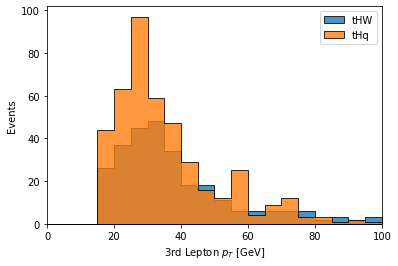

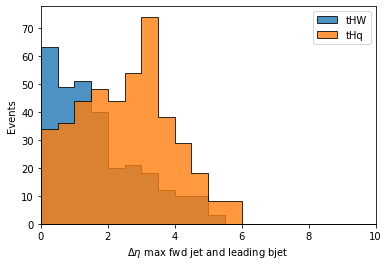

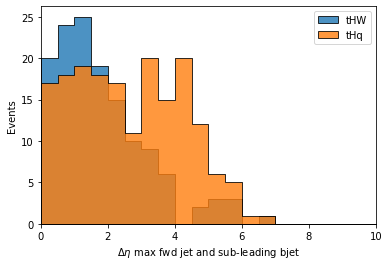

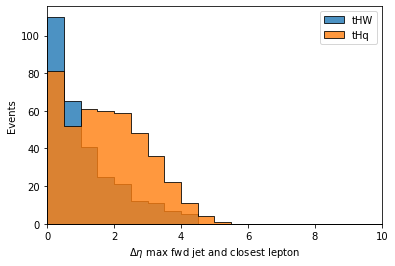

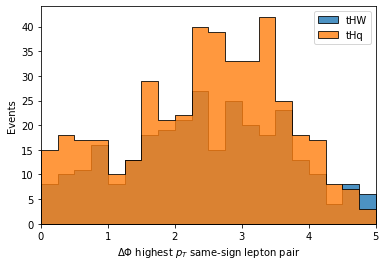

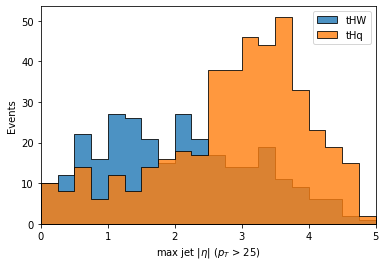

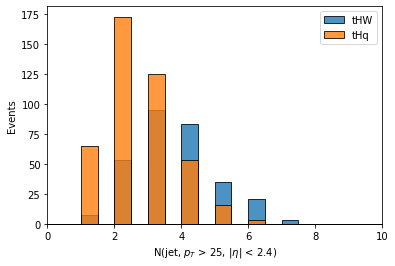

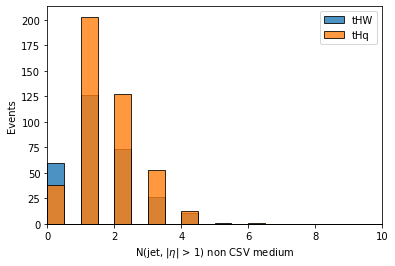

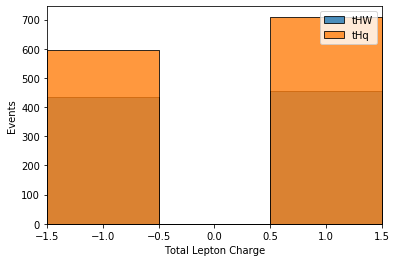

In [7]:
print('Three Lepton Channel')
hist.plot1d(output['lll_3rdLepton_pT'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})
hist.plot1d(output['lll_fwdJet_leadbJet'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})
hist.plot1d(output['lll_fwdJet_subleadbJet'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})
hist.plot1d(output['lll_fwdJet_closestLepton'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})
hist.plot1d(output['lll_highpT_sslp'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})
hist.plot1d(output['lll_jetMaxEta'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})
hist.plot1d(output['lll_NJetMED'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})
hist.plot1d(output['lll_NJetNONMED'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})
hist.plot1d(output['lll_TotalCharge'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})

mu-mu Channel


(<Figure size 432x288 with 1 Axes>,
 {<StringBin (tHW) instance at 0x7f5f691f88d0>: [<matplotlib.collections.PolyCollection at 0x7f5fc7b83940>],
  <StringBin (tHq) instance at 0x7f5fc792a470>: [<matplotlib.collections.PolyCollection at 0x7f5fc7b83240>],
  'legend': <matplotlib.legend.Legend at 0x7f5fc7b834e0>})

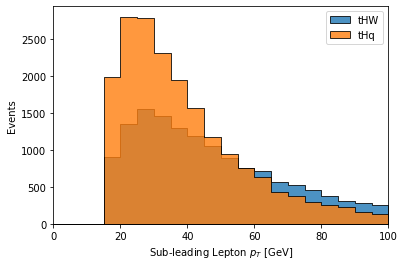

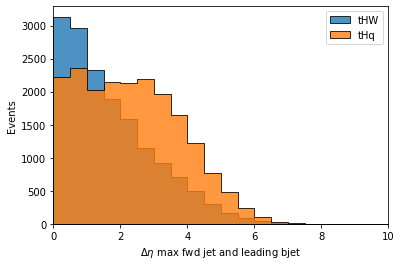

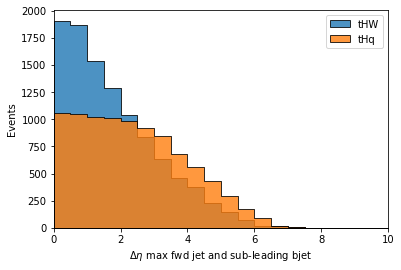

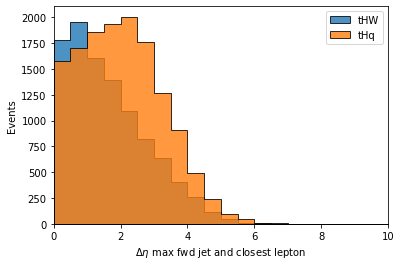

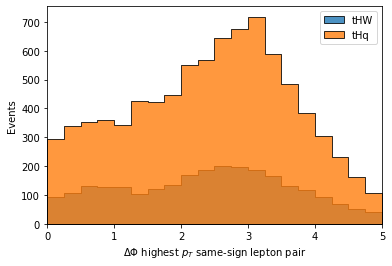

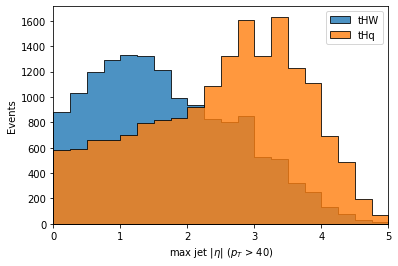

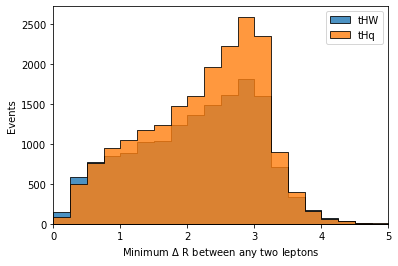

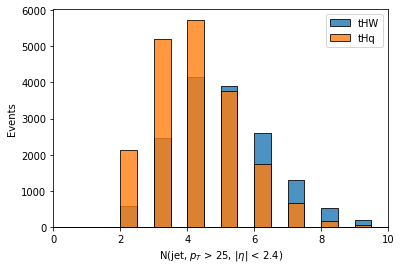

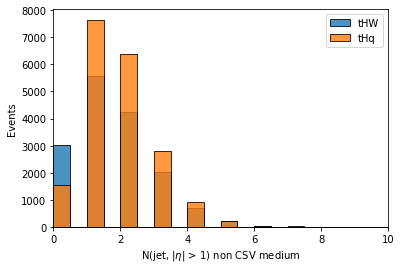

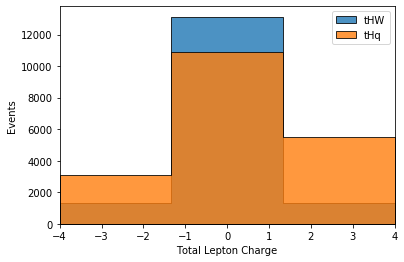

In [15]:
print('mu-mu Channel')
hist.plot1d(output['mumu_subleadLepton_pT'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})
hist.plot1d(output['mumu_fwdJet_leadbJet'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})
hist.plot1d(output['mumu_fwdJet_subleadbJet'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})
hist.plot1d(output['mumu_fwdJet_closestLepton'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})
hist.plot1d(output['mumu_highpT_sslp'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})
hist.plot1d(output['mumu_jetMaxEta'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})
hist.plot1d(output['mumu_minDelR'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})
hist.plot1d(output['mumu_NJetMED'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})
hist.plot1d(output['mumu_NJetNONMED'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})
hist.plot1d(output['mumu_TotalCharge'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})

e-mu Channel


(<Figure size 432x288 with 1 Axes>,
 {<StringBin (tHW) instance at 0x7f5fcd253b38>: [<matplotlib.collections.PolyCollection at 0x7f5fcd0b2ac8>],
  <StringBin (tHq) instance at 0x7f5f692045f8>: [<matplotlib.collections.PolyCollection at 0x7f5fcd0b2dd8>],
  'legend': <matplotlib.legend.Legend at 0x7f5fcd0da0f0>})

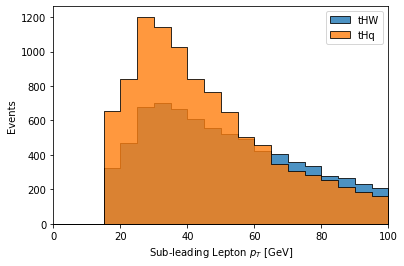

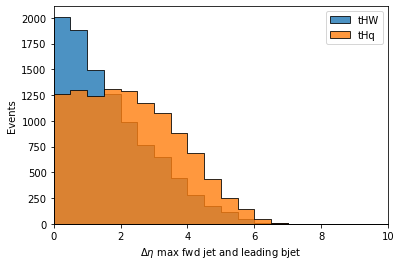

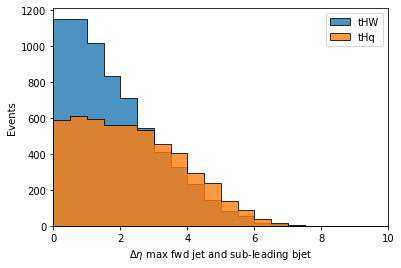

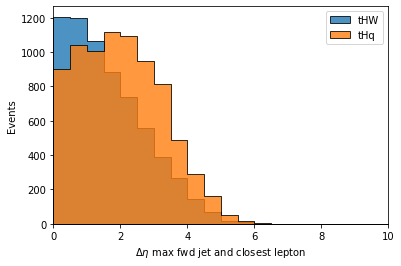

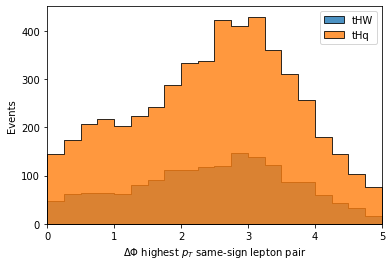

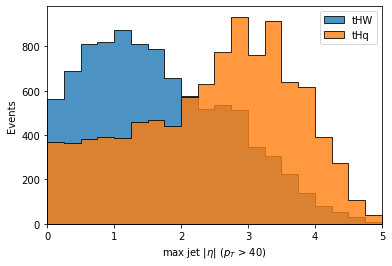

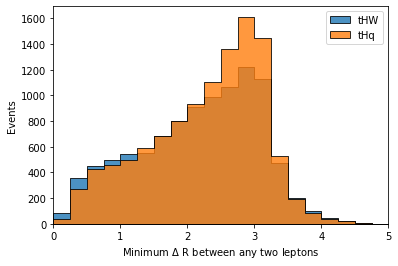

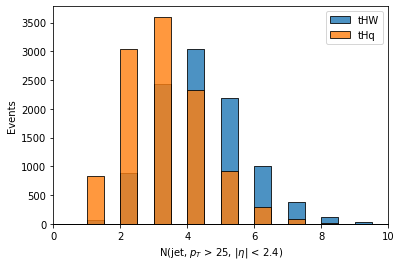

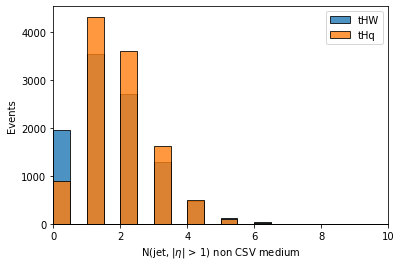

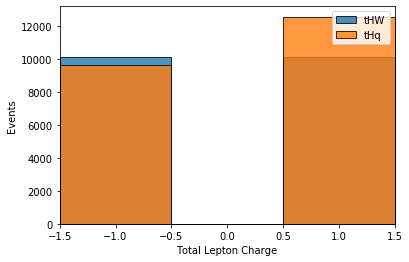

In [9]:
print('e-mu Channel')
hist.plot1d(output['emu_subleadLepton_pT'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})
hist.plot1d(output['emu_fwdJet_leadbJet'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})
hist.plot1d(output['emu_fwdJet_subleadbJet'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})
hist.plot1d(output['emu_fwdJet_closestLepton'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})
hist.plot1d(output['emu_highpT_sslp'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})
hist.plot1d(output['emu_jetMaxEta'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})
hist.plot1d(output['emu_minDelR'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})
hist.plot1d(output['emu_NJetMED'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})
hist.plot1d(output['emu_NJetNONMED'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})
hist.plot1d(output['emu_TotalCharge'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})

e-e Channel


(<Figure size 432x288 with 1 Axes>,
 {<StringBin (tHW) instance at 0x7f5fcd253b38>: [<matplotlib.collections.PolyCollection at 0x7f5fcd1cfeb8>],
  <StringBin (tHq) instance at 0x7f5f692045f8>: [<matplotlib.collections.PolyCollection at 0x7f5fcd1cf0b8>],
  'legend': <matplotlib.legend.Legend at 0x7f5fcd1cfc18>})

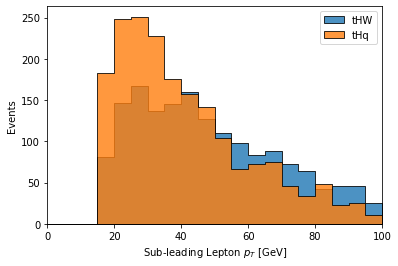

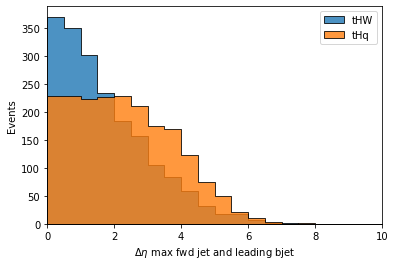

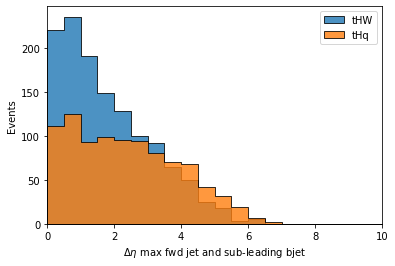

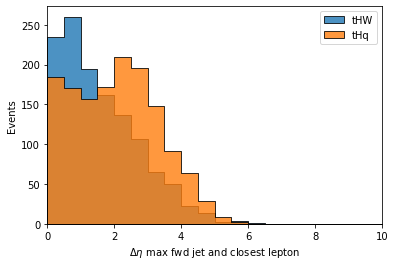

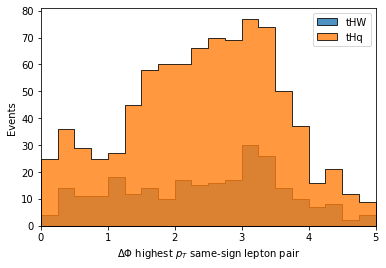

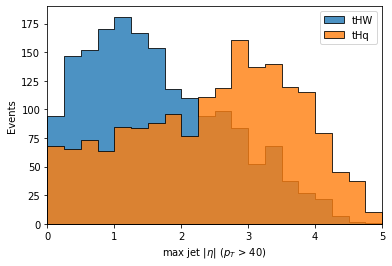

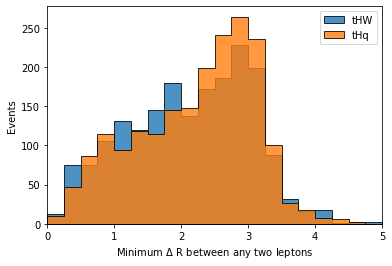

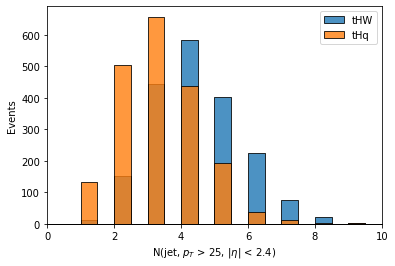

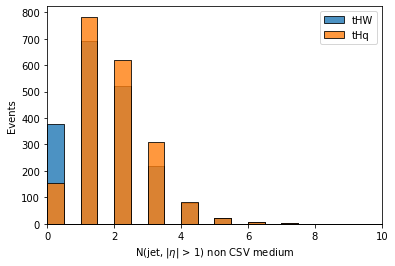

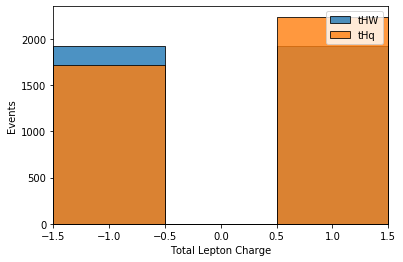

In [10]:
print('e-e Channel')
hist.plot1d(output['ee_subleadLepton_pT'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})
hist.plot1d(output['ee_fwdJet_leadbJet'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})
hist.plot1d(output['ee_fwdJet_subleadbJet'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})
hist.plot1d(output['ee_fwdJet_closestLepton'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})
hist.plot1d(output['ee_highpT_sslp'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})
hist.plot1d(output['ee_jetMaxEta'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})
hist.plot1d(output['ee_minDelR'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})
hist.plot1d(output['ee_NJetMED'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})
hist.plot1d(output['ee_NJetNONMED'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})
hist.plot1d(output['ee_TotalCharge'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})

In [ ]:
for key, value in output['cutflow'].items():
    print(key, value)